In [1]:
import scanpy as sc
import numpy as np
import all_utils_jup as my_func

# Load Velocyto Data

In [2]:
adata = sc.read_loom("Jup_files/Examples/HaCat/HaCat_MEF_A.loom",X_name="")

print("initial gene count: ",len(adata.var.index))
print("initial cell count: ",len(adata.obs.index))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


initial gene count:  60617
initial cell count:  2933


Filter out murine barcodes based on a list of barcodes from a textfile
Also makes variable names (genes) unique, done by adding a number string (1,2 etc...)

In [3]:
mm10_bc = []
for i in open("Jup_files/Examples/HaCat/HaCat_MEF_B_mus_musculus_barcodes.txt","r").readlines(): 
    mm10_bc.append(i.rstrip())

adata = my_func.filter_loom_barcode(adata,mm10_bc)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


# Quality control

In [4]:
#Load the gtf data using pyranges and extract the list of mitochondrial genes for later use
#gtf="Jup_files/Data/gencode.v33.annotation.gtf"
#MT_list=my_func.create_chrM_list(gtf)

#Load a list of mitochondrial genes from the dataset
path_MT='Jup_files/Data/chrM_unique.txt'
MT_list=my_func.get_chrM_list(path_MT)

... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


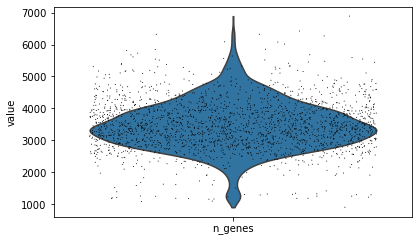

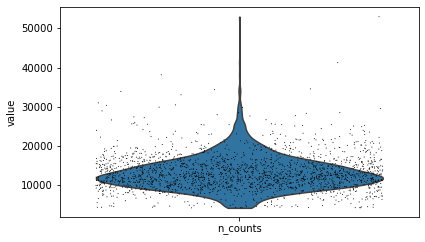

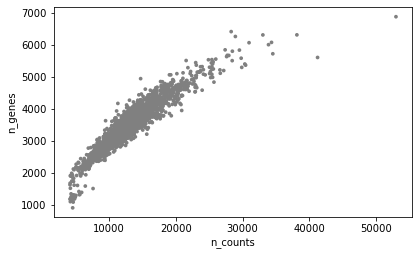

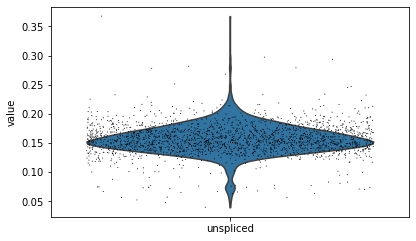

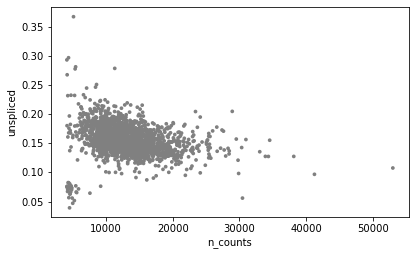

In [5]:
#Filter cells based on minimum gene_count per cell
sc.pp.filter_cells(adata,min_genes=500)

#Filter genes based on minimum number of cells expressing the gene
sc.pp.filter_genes(adata,min_cells=5)

#Filter cells based on number of reads per cell 
sc.pp.filter_cells(adata,min_counts=4000)

#Creates plots, allows for interpretation of which values should be used for unspliced filter in the next cell
my_func.scanpy_pp_plots(adata,MT_list,True,False,True)

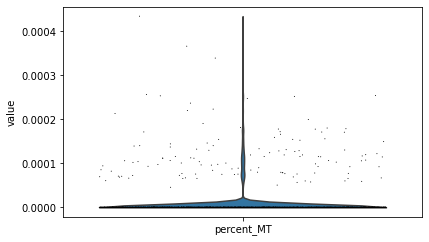

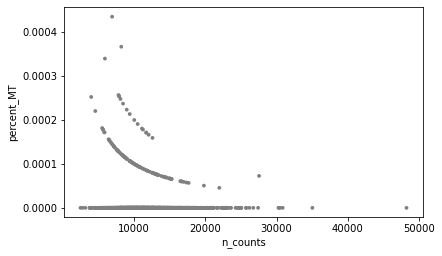

In [6]:
#Filter cells based on maximum unspliced percentage
my_func.filter_based_on_spliced_unspliced_ratio(adata,'unspliced',max_percent=25)

#Filter cells based on minimum unspliced percentage
my_func.filter_based_on_spliced_unspliced_ratio(adata,'unspliced',min_percent=10)

#Filter cells based on minimum intron count
my_func.filter_adata_using_min_intron_count(adata,1)

#Creates plots, allows for interpretation of which values should be used for mitochondrial filter in the next cell
my_func.scanpy_pp_plots(adata,MT_list,False,True,False)

final gene count:  15772
final cell count:  1966


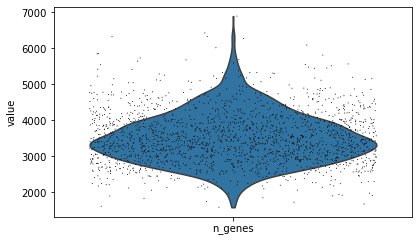

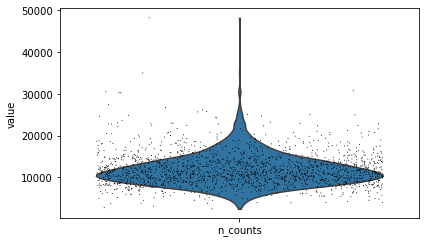

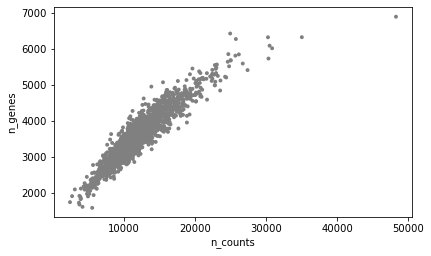

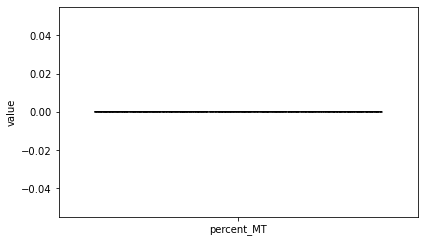

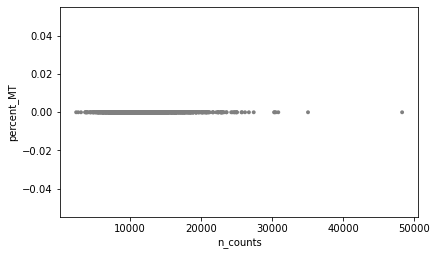

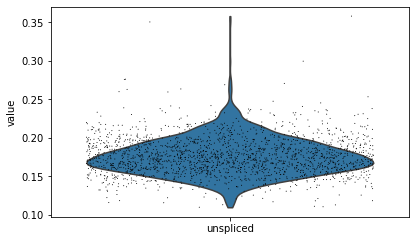

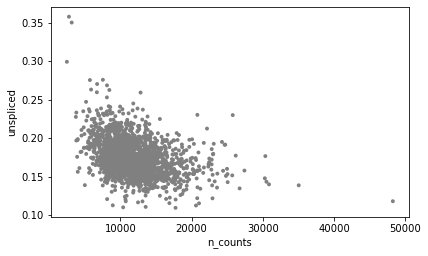

In [7]:
#Filter cells based on MT percentage
my_func.filter_MT_percent(adata,MT_list,0)

print("final gene count: ",len(adata.var.index))
print("final cell count: ",len(adata.obs.index))


#Visually check filter results
my_func.scanpy_pp_plots(adata,MT_list,True,True,True)

# Sort cells based on cell cycle phases

... storing 'phase' as categorical


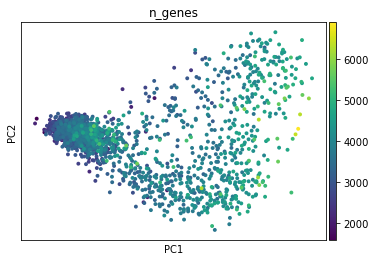

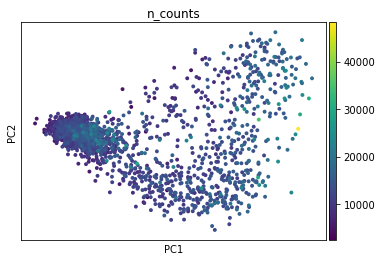

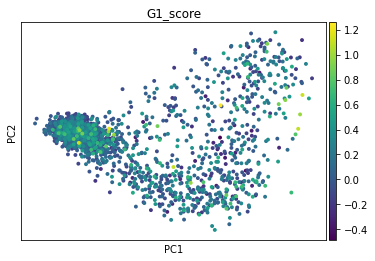

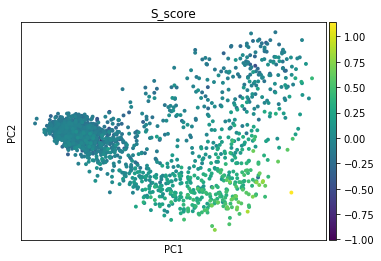

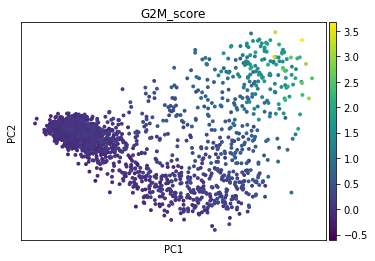

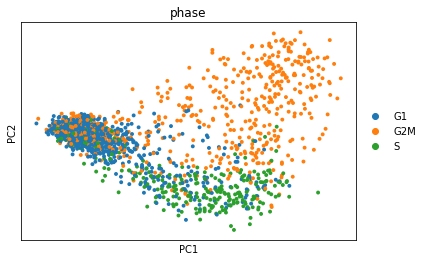

In [8]:
#Remove all gene that are not related to the cell cycle (highly_variable=False), the genes kept are located in the CC file

CC_path="Jup_files/Data/Original_cell_cycle_genes_with_new_candidates.csv"

my_func.my_score_genes_cell_cycle_improved(adata=adata,layer_choice='spliced', CC_path=CC_path)

sc.pp.normalize_total(adata, target_sum=1e6) #RPM normalized for all layers
sc.pp.log1p(adata)
adata.raw = adata

adata=my_func.selection_method(adata,highly_variable=False,CC_path=CC_path)

#Removes any genes with 0 reads
my_func.check_cols_and_rows(adata)

#Plot PCAs, visually check if regressing out is necessary
my_func.perform_scanpy_pca(adata,compute=True,exclude_gene_counts=False,exclude_CC=False)

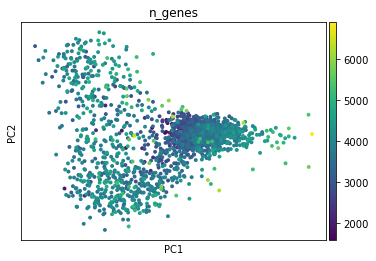

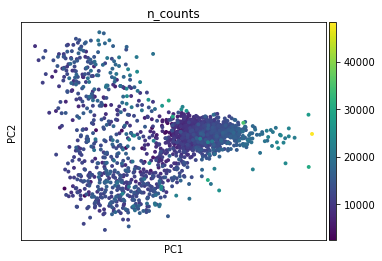

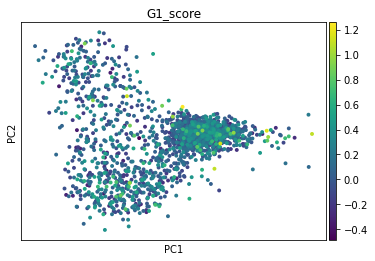

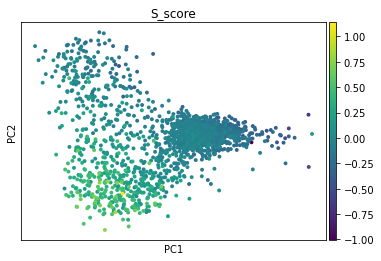

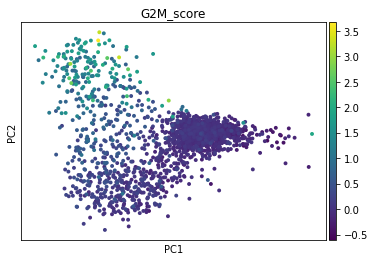

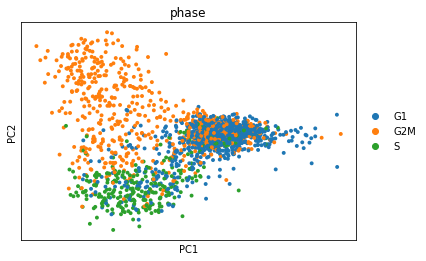

In [9]:
#Regress out n_counts and check PCAs again
sc.pp.regress_out(adata,['n_counts'])

my_func.perform_scanpy_pca(adata,compute=True,exclude_gene_counts=False,exclude_CC=False)

... storing 'phase' as categorical


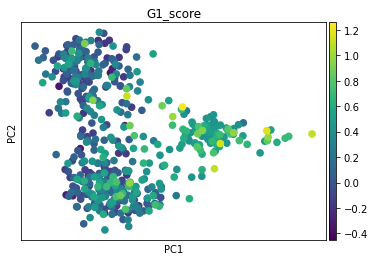

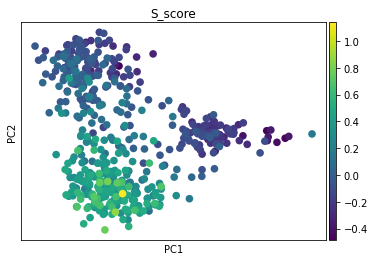

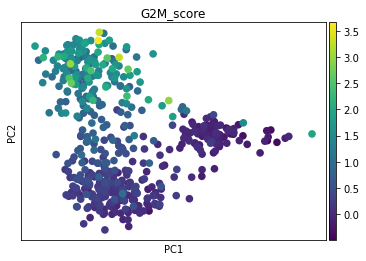

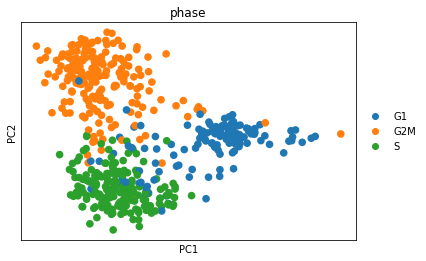

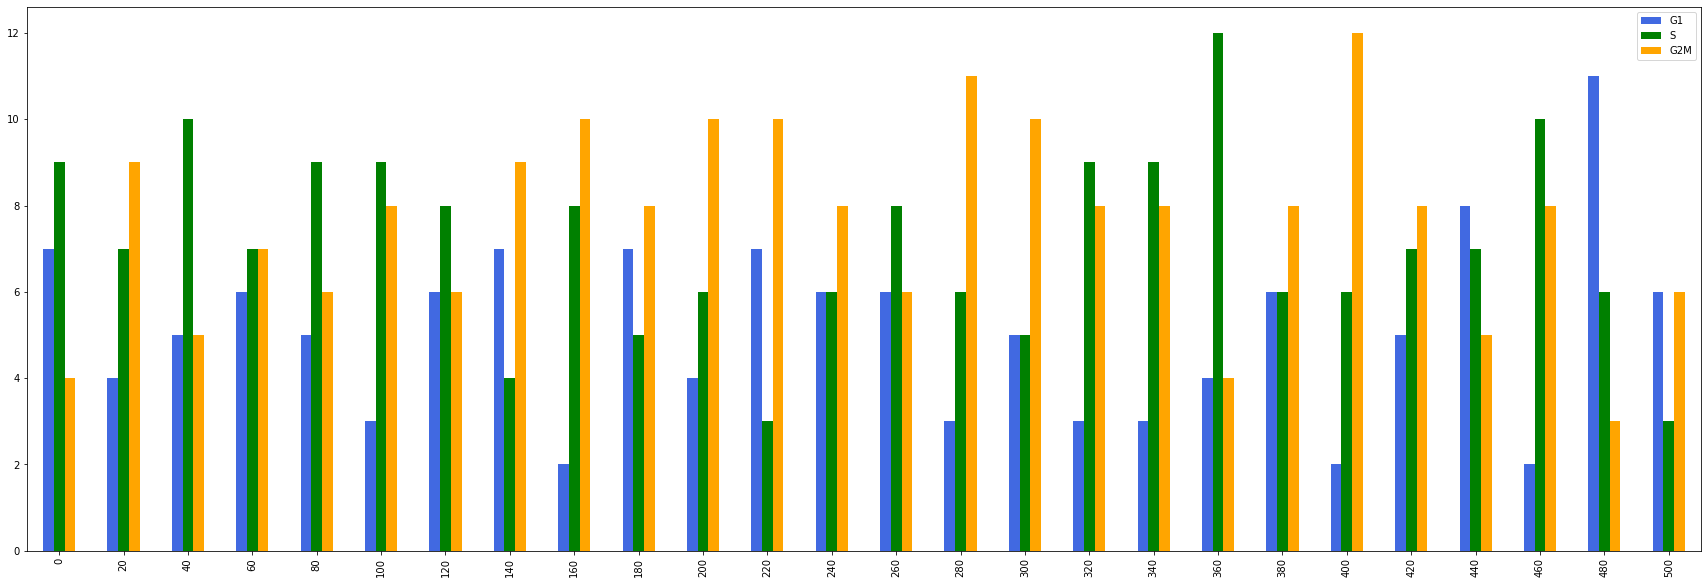

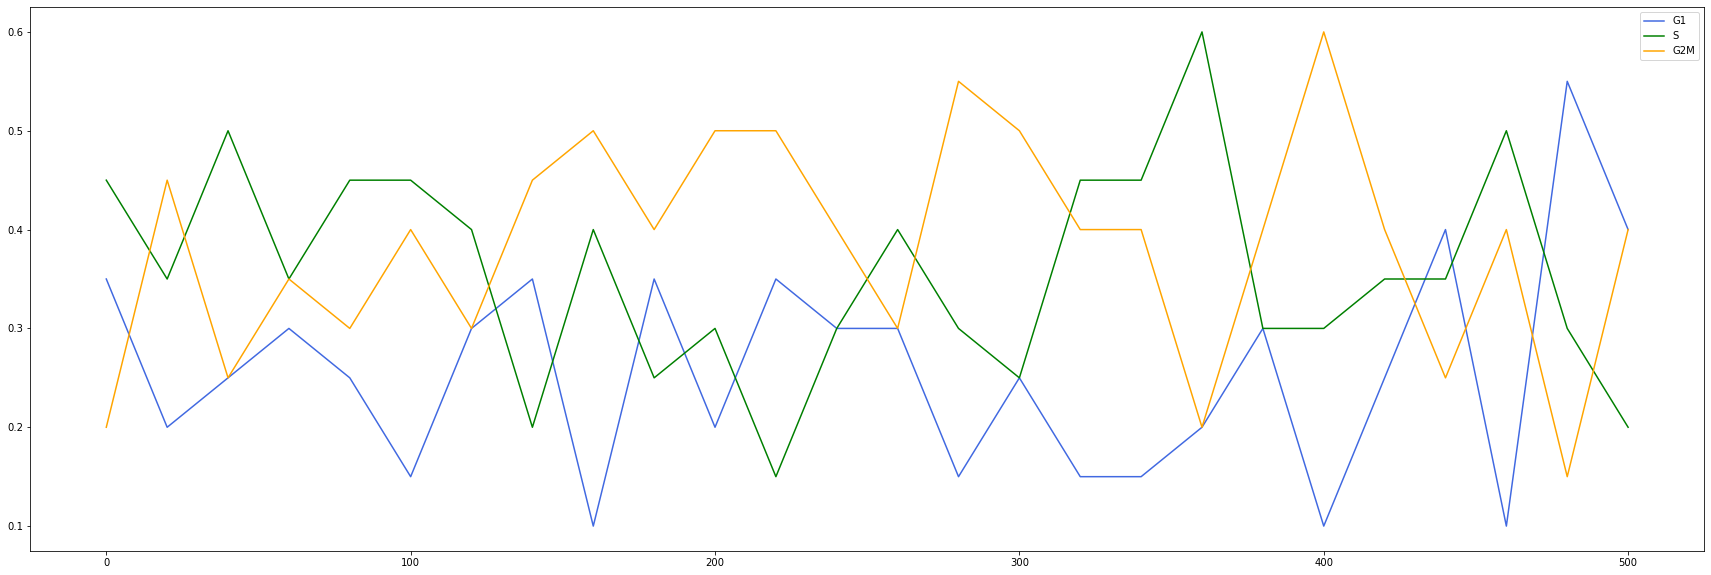

In [10]:
#Create a copy of adata in order to filter the copy and calculate the phase angle boundaries which will be used on the full dataset.
adata_check=adata.copy()

#Filter is done by presrving the top 10% of cells in each phase score
my_func.score_filter_reassign(adata_check,0.10)

#Visualize the filter results
my_func.perform_scanpy_pca(adata_check,compute=False,exclude_gene_counts=True,exclude_CC=False)
count_df, ratio_df = my_func.plot_phase_bar_dist(adata_check, 20, return_data=True, plot_path=None)

Trying to set attribute `.obs` of view, copying.


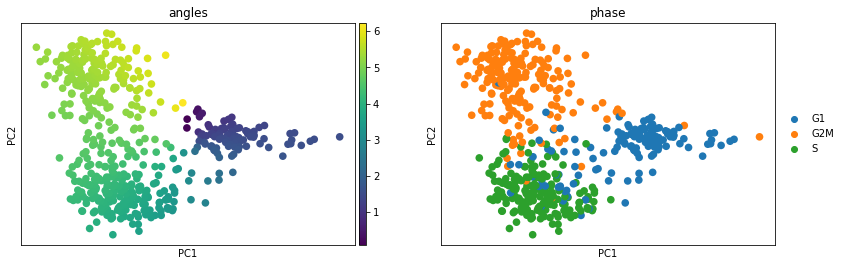

In [11]:
adata_check.obs['angles'] = my_func.compute_angles(adata_check.obsm['X_pca'][:,:2])
adata_check = adata_check[adata_check.obs['angles'].argsort(),:]
adata_check.obs['order'] = np.arange(len(adata_check.obs))

sc.pl.pca_scatter(adata_check, color=['angles','phase'], components=['1,2'], save=False)

/home/yohan/Internship/Jupyter_notebook/all_utils_jup.py:678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs['order'][data.obs['order'] < 0] += len(data.obs)
... storing 'phase' as categorical


G1 angle:  0.097279616
S angle:  2.4321318
G2M angle:  4.662306
new g1 count is  95
new s count is  225
new g2m count is  195


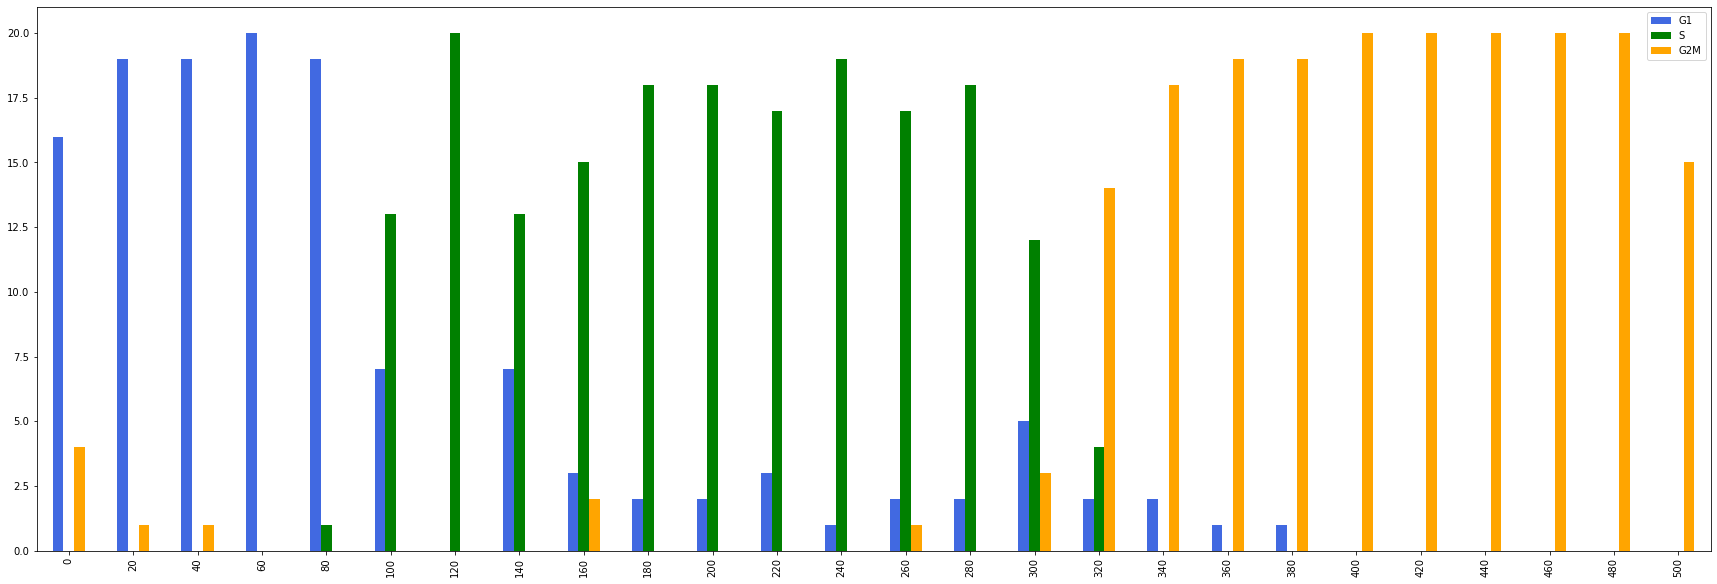

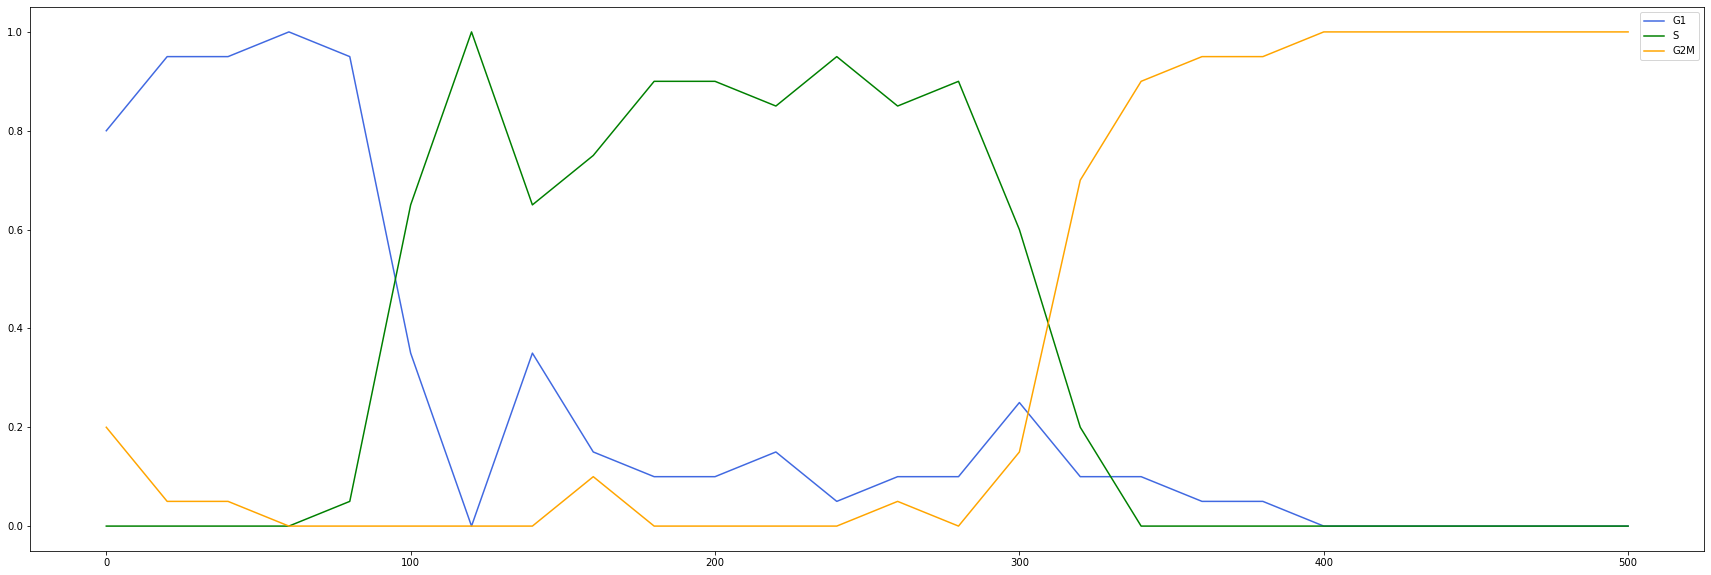

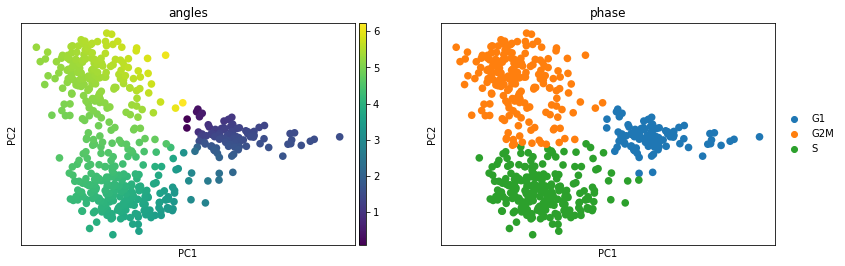

In [12]:
#Automatically find the orientation, necessary as a reversal of orientation can occur and function behaviour will change accordingly.
#The order is shifted in to best match the G2M/G1 transition point at the start point (order 0)
#Angles and phase angle boundaries are calculated, cells are reassigned on the filtered dataset to observe the results

orientation=my_func.auto_detect_orientation(adata_check)
adata_check,orientation=my_func.auto_shift_wrapper(adata_check,orientation)

count_df, ratio_df = my_func.plot_phase_bar_dist(adata_check, 20, return_data=True, plot_path=None)

g1_angle, s_angle, g2m_angle=my_func.find_angle_boundaries(adata_check)

my_func.phase_angle_assignment(adata_check,g1_angle,s_angle,g2m_angle)

sc.pl.pca_scatter(adata_check, color=[ 'angles', 'phase'], components=['1,2'], save=False)

Trying to set attribute `.obs` of view, copying.
... storing 'phase' as categorical


new g1 count is  1159
new s count is  490
new g2m count is  317


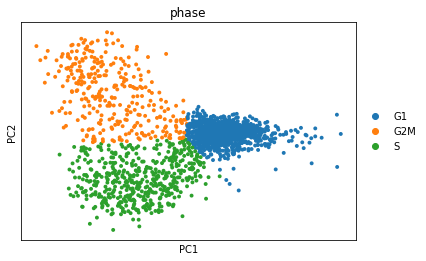

/home/yohan/Internship/Jupyter_notebook/all_utils_jup.py:678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.obs['order'][data.obs['order'] < 0] += len(data.obs)


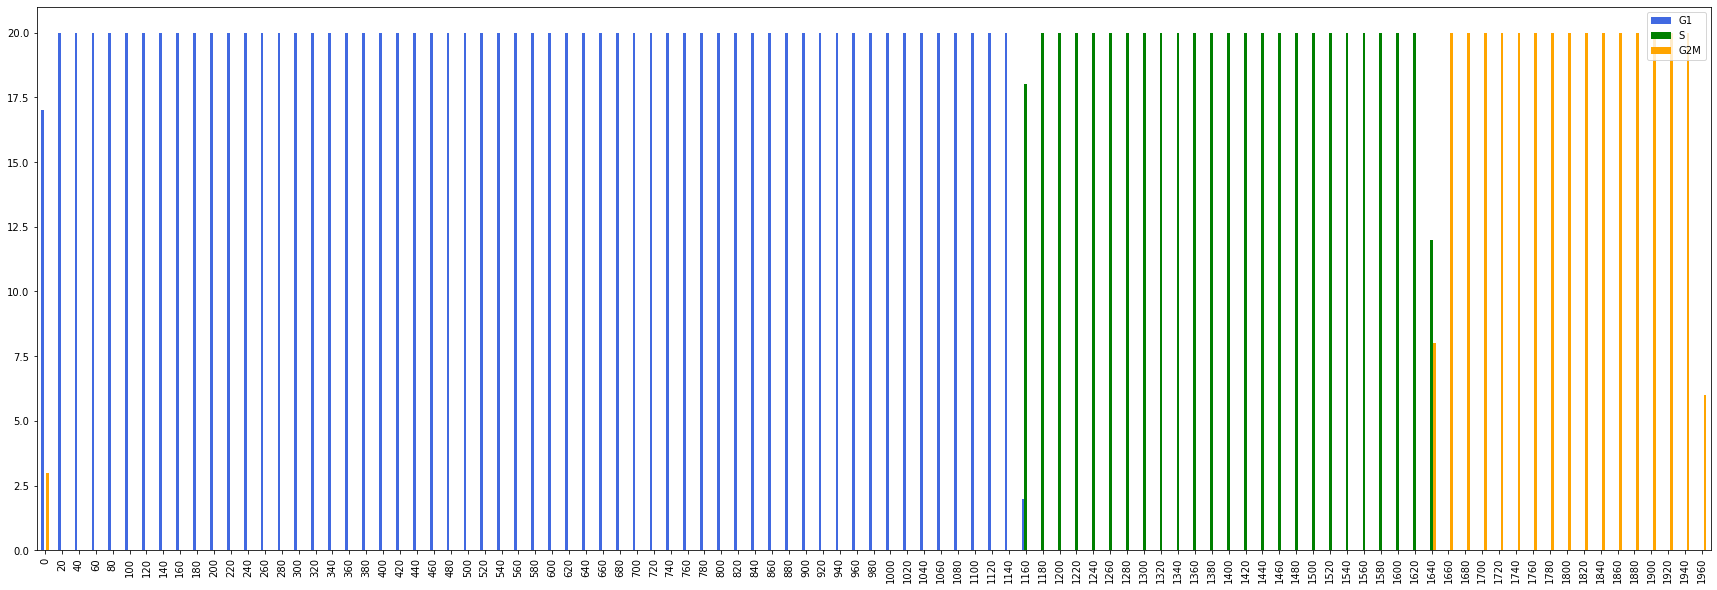

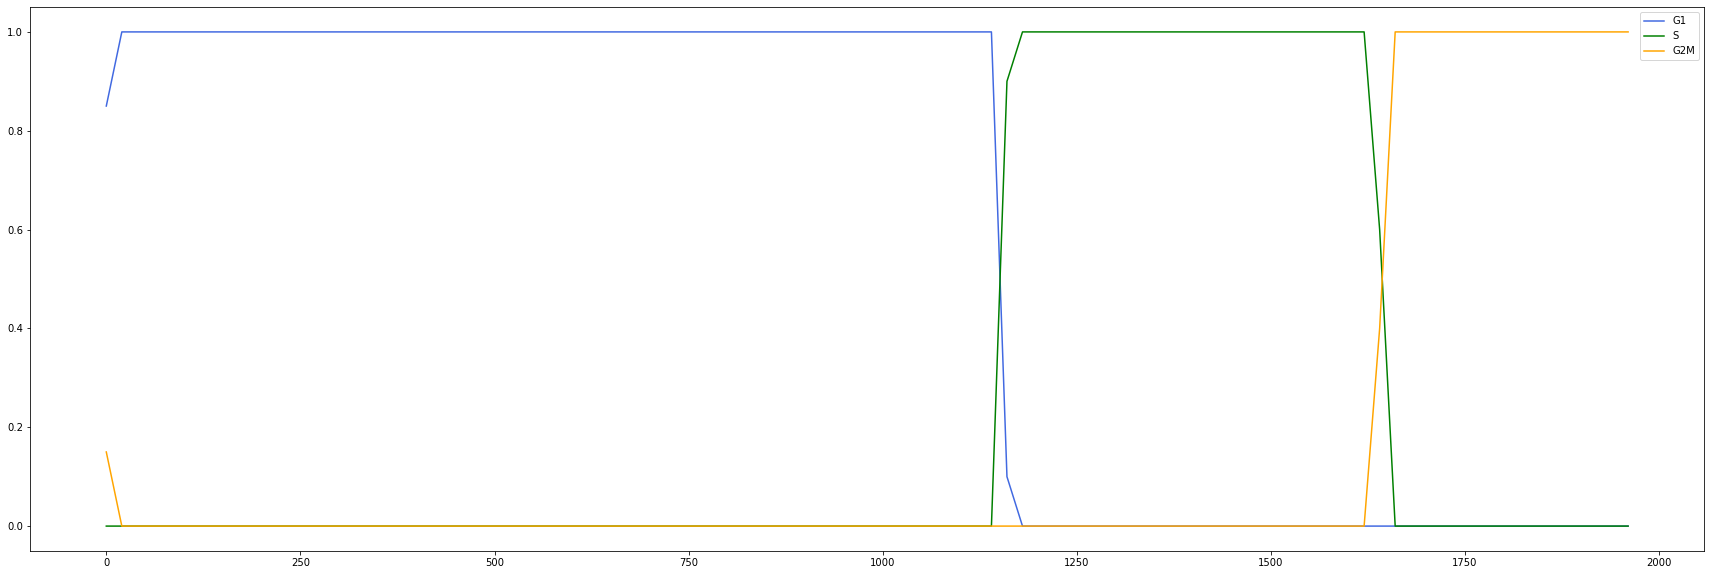

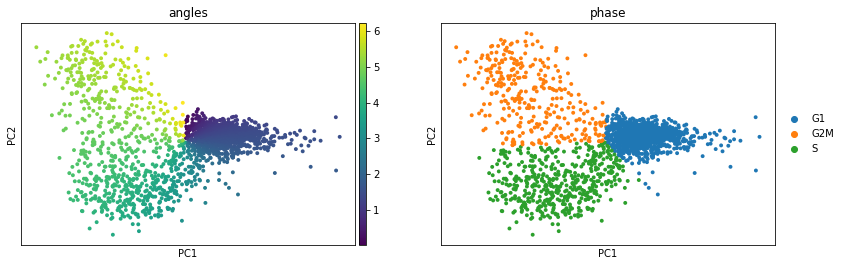

In [13]:
#Results from the filtered dataset are proper, angles are calculated on the non-fitlered dataset and cells are reassigned based on the phase angle boundaries
#Orientation is re-determined as a precaution and assigned to the anndata object to be carried over to the next functions
#Results are visualized

adata.obs['angles'] = my_func.compute_angles(adata.obsm['X_pca'][:,:2])
adata = adata[adata.obs['angles'].argsort(),:]
adata.obs['order'] = np.arange(len(adata.obs))


my_func.phase_angle_assignment(adata,g1_limit=g1_angle,s_limit=s_angle,g2m_limit=g2m_angle)
sc.pl.pca_scatter(adata, color=['phase'], components=['1,2'], save=False)

adata,orientation=my_func.auto_shift_wrapper(adata,orientation)

count_df, ratio_df = my_func.plot_phase_bar_dist(adata, 20, return_data=True, plot_path=None)

adata=my_func.find_angle_boundaries_post_reassignment(adata,orientation=orientation)

sc.pl.pca_scatter(adata, color=[ 'angles', 'phase'], components=['1,2'], save=False)

orientation=my_func.auto_detect_orientation(adata)

ori_arr=np.asarray([orientation]*len(adata.obs))

adata.obs["orientation"]=ori_arr[0]

In [14]:
#Results are written to a loom file as velocyto requires reading a loom file to load a velocyto object

loom_path="Jup_files/Results/pp_results_for_velocyto.loom"
adata.write_loom(loom_path, write_obsm_varm=True)

# Calculate gene velocity

In [15]:
#Set up imports and load loom file into velocyto object
import matplotlib.pyplot as plt
import velocyto as vcy
plt.rcParams['pdf.fonttype'] = 42

vlm = vcy.VelocytoLoom(loom_path)

In [16]:
# Read column attributes from the loom file and specify colors, set vlm.colorandum
colors_dict = {'G1':np.array([52, 127, 184]),
  'S':np.array([37,139,72]),
  'G2M':np.array([223,127,49]),}
colors_dict = {k:v/256 for k, v in colors_dict.items()}
vlm.set_clusters(vlm.ca["phase"], cluster_colors_dict=colors_dict)

#Downsampling cells - equalize levels of each type/phase
tosample = int(np.ceil(np.mean(np.unique(vlm.ca["phase"], return_counts=1)[1])))
downsample_ixs = []
for ct in np.unique(vlm.ca["phase"]):
    ixs = np.where(vlm.ca["phase"] == ct)[0]
    downsample_ixs.append(np.random.choice(ixs, min(tosample, len(ixs)), replace=False))
downsample_ixs = np.concatenate(downsample_ixs)
vlm.filter_cells(bool_array=np.in1d(np.arange(vlm.S.shape[1]), downsample_ixs))  #Downsample filter

#Assign the CellID and Gene variables as it is what is searched for by velocyto functions
vlm.ca["CellID"]=vlm.ca["obs_names"]
vlm.ra['Gene']=vlm.ra["var_names"]

#Create a boundary dict which associates finds the order of the first cell of each phase. Also stores colors for plot usage later on.
boundary_dict=my_func.create_boundary_dict(vlm)

<Figure size 648x648 with 0 Axes>

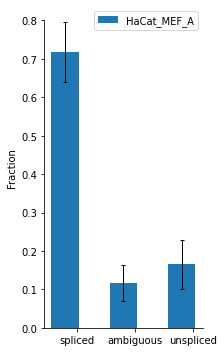

In [17]:
#Standard velocyto plot to observe fractions in the velocyto object
plt.figure(None,(9,9))
vlm.plot_fractions()
plt.show()

In [18]:
#filters specific layers based on specified quantites in dp (beginning of code)
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=10, min_expr_counts_U=30, min_cells_express_U=10)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=False)


#Normalize unspliced and spliced layer
combined_size = (vlm.S.sum(0) / np.percentile(vlm.S.sum(0), 95)) + (vlm.initial_cell_size / np.percentile(vlm.initial_cell_size, 95))
combined_Usize = (vlm.U.sum(0) / np.percentile(vlm.U.sum(0), 95)) + (vlm.initial_Ucell_size / np.percentile(vlm.initial_Ucell_size, 95))
vlm._normalize_S(relative_size=0.25*combined_size*np.median(vlm.S.sum(0)),
                 target_size=np.median(vlm.S.sum(0)))
vlm._normalize_U(relative_size=0.5*combined_Usize*np.median(vlm.U.sum(0)),
                 target_size=np.median(vlm.U.sum(0)))

vlm.perform_PCA()

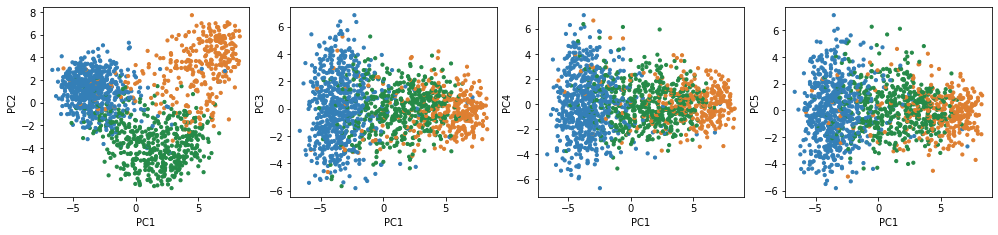

In [19]:
#Plot PC1 vs PC2,PC3,PC4,and PC5
plt.figure(None, (17,3.5))
plt.subplot(141)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,1], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.subplot(142)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,2], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC3")
plt.subplot(143)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,3], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC4")
plt.subplot(144)
vcy.scatter_viz(vlm.pcs[:,0], vlm.pcs[:,4], c=vlm.colorandum,s=10)
plt.xlabel("PC1"); plt.ylabel("PC5")
plt.show()

/home/yohan/miniconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=50 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/home/yohan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/yohan/miniconda3/lib/python3.7/site-packages/rpy2/robjects/packages_utils.py:127: UserWarning: Conflict when converting R symbols in the package "princurve" to Python symbols: 
-lines_principal_curve -> lines.principal_curve, lines.principal.curve
- plot_principal_curve -> plot.principal_curve, plot.principal.curve
- points_principal_curve -> points.principal_curve, points.principal.curve
  warn(msg)


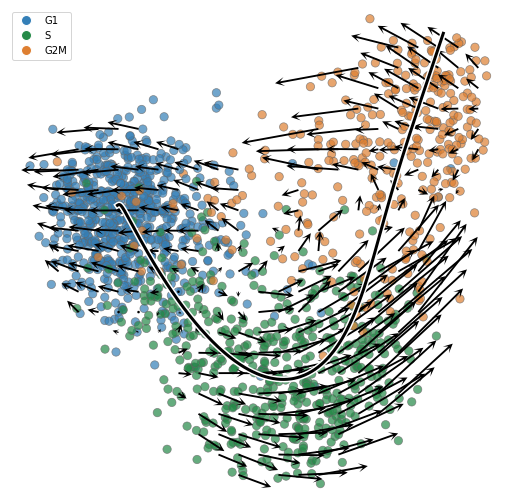

In [20]:
#Call necessary functions to create the velocity field

from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])   #We use PC1 through 3
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()


k = 550
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.006))[0][0]
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))

vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

vlm.normalize(which="imputed", size=False, log=True)


vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

#Use correlation to estimate transition probabilities for every cells to its embedding neighborhood
#hidim --> high dimensional space
#embed --> Name of the attribute containing the embedding, here it is PCs, but it could be  ts
#Transform --> Transformation that is applied on the hidim. Can be sqrt or log
#psc --> pseudocount added in variance normalizing transform
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)


#Use the transition probability to project the velocity direction on the embedding
#sigma_corr --> the kernel scalling
#expression scaling --> rescaled arrows to penalize arrows that explain very small amoung of expression differences
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
#Expression scaling to False makes arrows larger and 'curvier' as no penalties implemented


#Calculate the velocity using a point on a regular grid and a gaussian kernel
#steps --> number of steps in the grid for each axis
vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25), n_neighbors=150)

my_func.plot_velocity_field(vlm)

# Other types of visualization

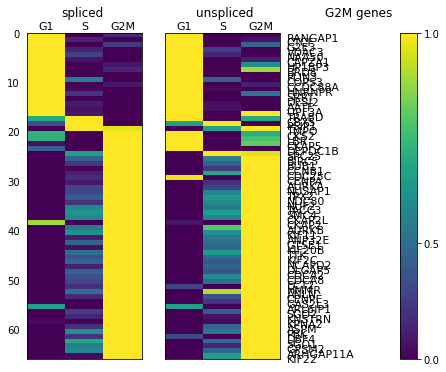

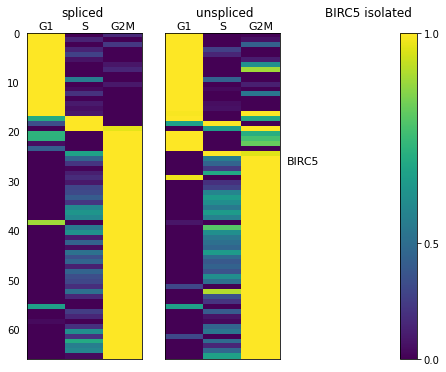

In [21]:
#Example of how the bar plots work

G1_list,S_list,G2M_list=my_func.prepare_CC_lists(CC_path)
g1_in_data=[]
for i in G1_list:
    if i in vlm.ra['Gene']:
        g1_in_data.append(i)
        
s_in_data=[]
for i in S_list:
    if i in vlm.ra['Gene']:
        s_in_data.append(i)
        
g2m_in_data=[]
for i in G2M_list:
    if i in vlm.ra['Gene']:
        g2m_in_data.append(i)

my_func.create_bar_plots_custom(vlm,gene_list=g2m_in_data,second_gene_list=None,order=[0,2,1],plot_title='G2M genes',y_label=True)
my_func.create_bar_plots_custom(vlm,gene_list=[g2m_in_data[0]],second_gene_list=g2m_in_data,order=[0,2,1],plot_title=g2m_in_data[0]+' isolated',y_label=True)

In [22]:
#Markov plots show the speculated start and end points of the dataset. A non-markov pca field is also generated for comparison.
#my_func.plot_markov(vlm)

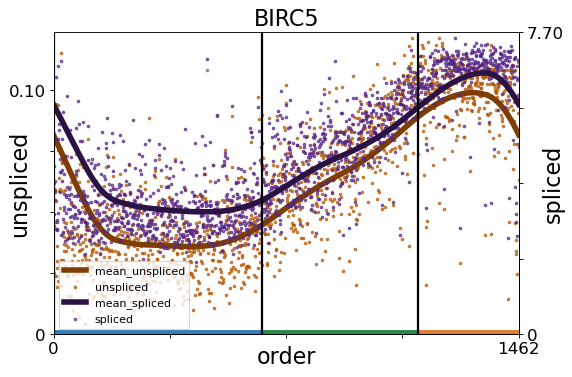

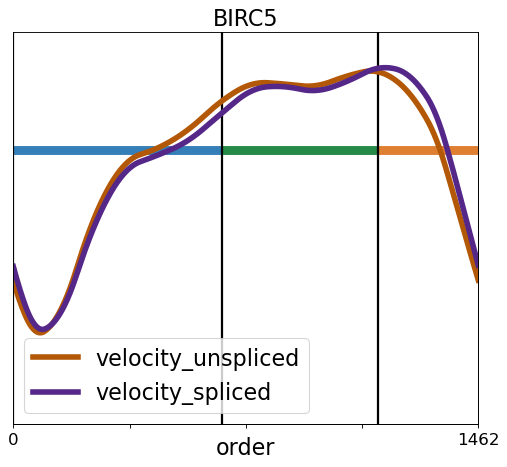

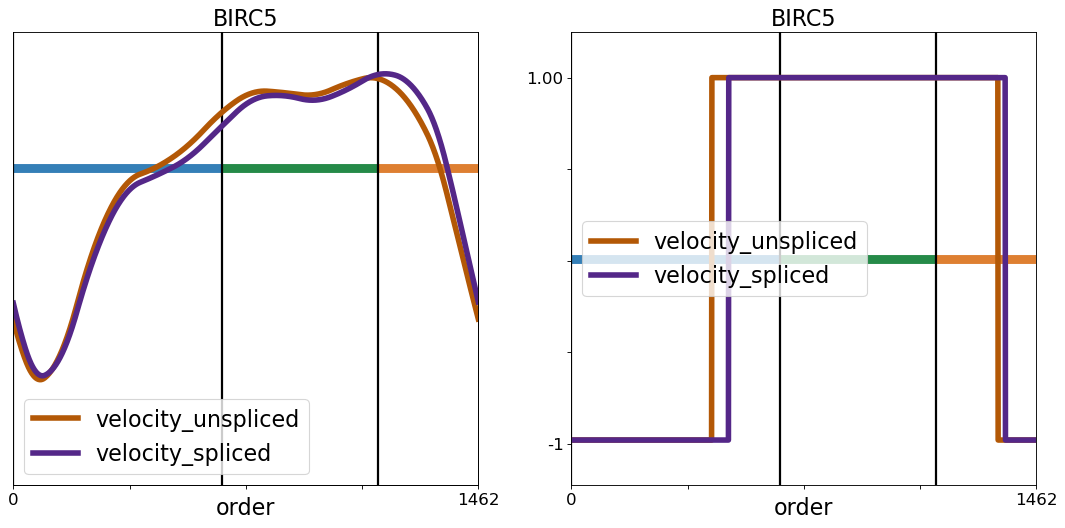

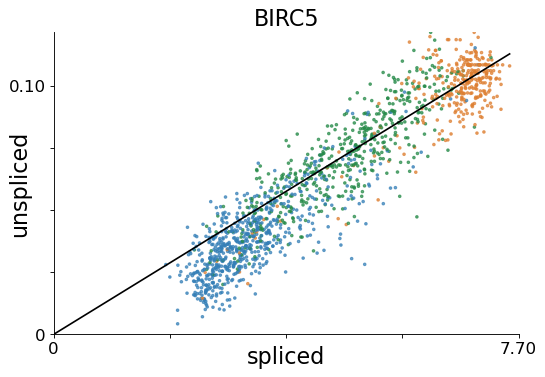

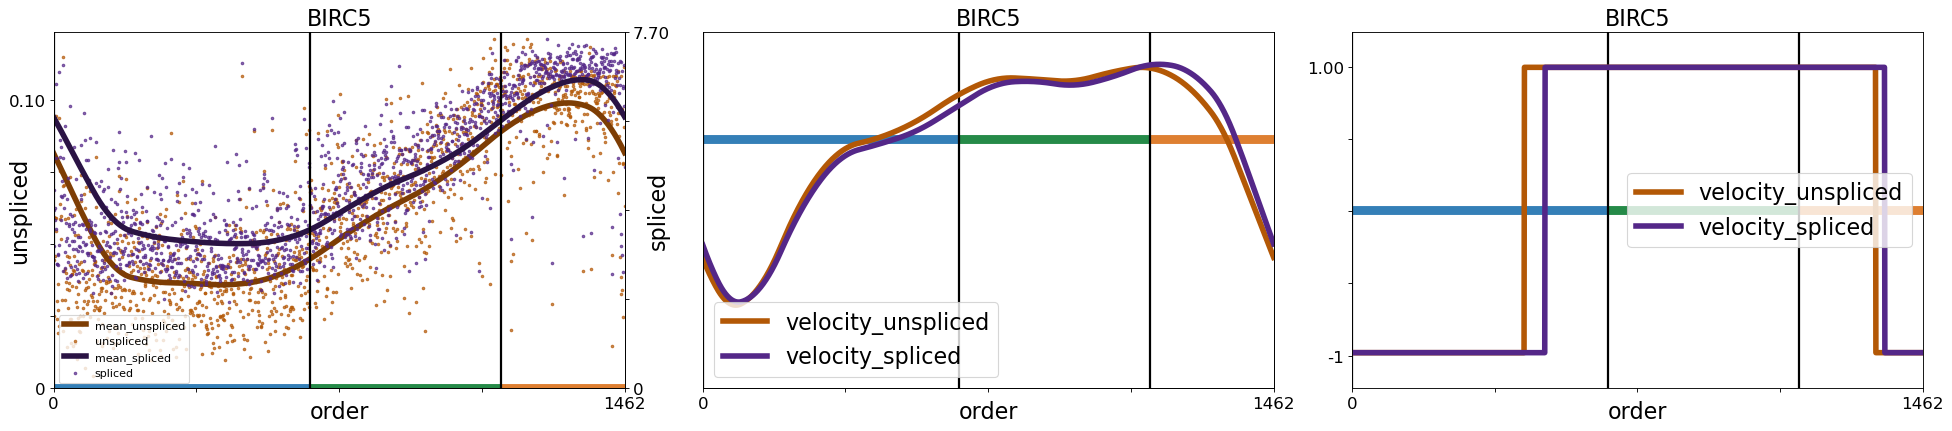

In [23]:
#Different visualizations for individual genes

my_func.plot_layers(vlm,[g2m_in_data[0]],boundary_dict)

my_func.plot_velocity(vlm,[g2m_in_data[0]],boundary_dict,do_lines=True,do_counts=False)

my_func.plot_velocity(vlm,[g2m_in_data[0]],boundary_dict,do_lines=True,do_counts=True)

my_func.plot_phase_portrait(vlm,[g2m_in_data[0]])

my_func.plot_grid_of_figures(vlm,[g2m_in_data[0]],boundary_dict)

# Identify genes with regulation behaviour

In [25]:
delay_df=my_func.create_delay_dataframe(vlm)
delay_df.to_csv('Jup_files/delay_DFs/HaCat/delay_A.csv',index=False)


TS_path='Jup_files/Data/Predicted_Targets_Context_Scores.default_predictions.txt'

# Calculate significance using spearman's correlation miRNA100+

In [ ]:
path_miRNA='Jup_files/Examples/HaCat/categorized_HaCat_miRNA_100.csv'
my_func.spearman_analysis(delay_df,TS_path,path_miRNA)

# Calculate significance using spearman's correlation miRNA1000+

In [ ]:
path_miRNA='Jup_files/Examples/HaCat/categorized_HaCat_miRNA_1000.csv'
my_func.spearman_analysis(delay_df,TS_path,path_miRNA)